In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from Temis.LogisticRegression import LogisticRegression
from sklearn.linear_model import LogisticRegression as SklearnLR

# ---------------------------------- #
# These metrics will be replaced with the ones from sklearn.
# from Temis.metrics.accuracy import compute_accuracy
# from Temis.metrics.precision import compute_precision
# from Temis.metrics.recall import compute_recall
# from Temis.metrics.f1_score import compute_f1
# ---------------------------------- #
from Temis.metrics.brier_score import compute_brier
from Temis.fairness_metrics.spd import compute_spd
from Temis.fairness_metrics.dir import compute_dir
from Temis.fairness_metrics.aod import compute_aod
from Temis.fairness_metrics.aaod import compute_aaod

from Temis.comparison_utils.cmp_fairness import compare_fairness 

# Importing Dataset.

In [2]:
path_dataset = os.path.join('..', 'datasets', 'german', 'german.data-numeric')
col_names = [f'feature_{i}' for i in range(1,25)] + ['label']

try:
    print(f'Importing data from: {path_dataset}')
    df = pd.read_csv(
        path_dataset,
        header=None,
        sep='\s+',
        engine='python',
        names=col_names
    )
    print(df.head())
except FileNotFoundError:
    print('Failed importing data')

Importing data from: ..\datasets\german\german.data-numeric
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          1          6          4         12          5          5   
1          2         48          2         60          1          3   
2          4         12          4         21          1          4   
3          1         42          2         79          1          4   
4          1         24          3         49          1          3   

   feature_7  feature_8  feature_9  feature_10  ...  feature_16  feature_17  \
0          3          4          1          67  ...           0           0   
1          2          2          1          22  ...           0           0   
2          3          3          1          49  ...           0           0   
3          3          4          2          45  ...           0           0   
4          3          4          4          53  ...           1           0   

   feature_18  feature_19  feature_20 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['label']).to_numpy(),
    df['label'].to_numpy(),
    test_size=0.2,
    random_state=42
)

''' 
Correcting dataset labels from {1, 2} to {0, 1}.
'''
y_train = y_train - 1
y_test = y_test - 1 

In [4]:
# Debugging:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')  

X_train shape: (800, 24)
y_train shape: (800,)
X_test shape: (200, 24)
y_test shape: (200,)


In [9]:
lrs = np.logspace(-4, -1, 4)
epochs = 100

acc_results = []
for lr in lrs:
    model = LogisticRegression(lr=lr, epochs=epochs)
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    acc = accuracy_score(y_test, pred_test)
    auc = roc_auc_score(y_test, pred_test)

    print(f'LR: {lr},\t Accuracy: {acc},\t AUC: {auc}')
    

LR: 0.0001,	 Accuracy: 0.74,	 AUC: 0.5642505108787114
LR: 0.001,	 Accuracy: 0.745,	 AUC: 0.5825820411107104
LR: 0.01,	 Accuracy: 0.705,	 AUC: 0.5
LR: 0.1,	 Accuracy: 0.705,	 AUC: 0.5


In [22]:
# My LogisticRegression
my_model = LogisticRegression(lr = 0.001, epochs = 100)
my_model.fit(X_train, y_train)
my_pred_test = model.predict(X_test)
my_prob_test = model.predict_probability(X_test)

# Sklearn LogisticRegression lbfgs
sk_model = SklearnLR(max_iter=1000, solver='lbfgs')
sk_model.fit(X_train, y_train)
sk_pred_test = sk_model.predict(X_test)
sk_prob_test = sk_model.predict_proba(X_test)[:, 1]

# Sklearn LogisticRegression liblinear
sk_model_lib = SklearnLR(max_iter=1000, solver='liblinear')
sk_model_lib.fit(X_train, y_train)
sk_pred_test_lib = sk_model_lib.predict(X_test)
sk_prob_test_lib = sk_model_lib.predict_proba(X_test)[:, 1]

# Sklearn LogisticRegression newton-cg
sk_model_newton = SklearnLR(max_iter=1000, solver='newton-cg')
sk_model_newton.fit(X_train, y_train)
sk_pred_test_newton = sk_model_newton.predict(X_test)
sk_prob_test_newton = sk_model_newton.predict_proba(X_test)[:, 1]

print(f"My Model - \t\t\tAcc: {accuracy_score(y_test, my_pred_test)} \t AUC: {roc_auc_score(y_test, my_prob_test)}")
print(f"Sk Model - \t\t\tAcc: {accuracy_score(y_test, sk_pred_test)} \t AUC: {roc_auc_score(y_test, sk_prob_test)}")
print(f"Sk Model Liblinear - \t\tAcc: {accuracy_score(y_test, sk_pred_test_lib)} \t AUC: {roc_auc_score(y_test, sk_prob_test_lib)}")
print(f"Sk Model Newton - \t\tAcc: {accuracy_score(y_test, sk_pred_test_newton)} \t AUC: {roc_auc_score(y_test, sk_prob_test_newton)}")

My Model - 			Acc: 0.755 	 AUC: 0.7464839523981248
Sk Model - 			Acc: 0.78 	 AUC: 0.7996153383820171
Sk Model Liblinear - 		Acc: 0.77 	 AUC: 0.8029811275393677
Sk Model Newton - 		Acc: 0.78 	 AUC: 0.7996153383820171


In [ ]:
# Preparing Models for Future Comparison.
model = LogisticRegression(lr=0.001, epochs=100)
model.fit(X_train, y_train)
my_pred_test = model.predict(X_test)
my_prob_test = model.predict_probability(X_test)

sk_model = SklearnLR(max_iter=1000, solver='liblinear')
sk_model.fit(X_train, y_train)
sk_pred_test = sk_model.predict(X_test)
sk_prob_test = sk_model.predict_proba(X_test)[:, 1]

print(f"My Model - \t\Acc: {accuracy_score(y_test, my_pred_test)} \t AUC: {roc_auc_score(y_test, my_prob_test)}")
print(f"Sk Model - \t\Acc: {accuracy_score(y_test, sk_pred_test)} \t AUC: {roc_auc_score(y_test, sk_prob_test)}")

My Model - 			Acc: 0.735 	 AUC: 0.7700444764995793
Sk Model - 			Acc: 0.77 	 AUC: 0.8029811275393677


In [27]:
print(f'Acc:\t\tMy_Model: {accuracy_score(y_test, my_pred_test):.2f}\tSK_Model: {accuracy_score(y_test, sk_pred_test):.2f}')
print(f'AUC:\t\tMy_Model: {roc_auc_score(y_test, my_prob_test):.2f}\tSK_Model: {roc_auc_score(y_test, sk_prob_test):.2f}')
print(f'Precision:\tMy_Model: {precision_score(y_test, my_pred_test):.2f}\tSK_Model: {precision_score(y_test, sk_pred_test):.2f}')
print(f'Recall:\t\tMy_Model: {recall_score(y_test, my_pred_test):.2f}\tSK_Model: {recall_score(y_test, sk_pred_test):.2f}')
print(f'F1-Score:\tMy_Model: {f1_score(y_test, my_pred_test):.2f}\tSK_Model: {f1_score(y_test, sk_pred_test):.2f}')
print(f'Brier-Score:\tMy_Model: {compute_brier(y_test, my_prob_test):.2f}\tSK_Model: {compute_brier(y_test, sk_prob_test):.2f}')

Acc:		My_Model: 0.73	SK_Model: 0.77
AUC:		My_Model: 0.77	SK_Model: 0.80
Precision:	My_Model: 0.65	SK_Model: 0.66
Recall:		My_Model: 0.22	SK_Model: 0.46
F1-Score:	My_Model: 0.33	SK_Model: 0.54
Brier-Score:	My_Model: 0.17	SK_Model: 0.15


# Identifying Binary Features
Identify features that can be used in computing Fairness Metrics, i.e., find features such that Z represents a group between value priv and unpr.

In [5]:
binary_features = []
for i in range(X_train.shape[1]):
    if np.all(np.isin(X_train[:, i], [0, 1])):
        binary_features.append(i)

print(f'Binary features: {binary_features}')

Binary features: [15, 16, 17, 18, 19, 20, 21, 22, 23]


In [36]:
score_my_model = 0 
score_sk_model = 0
score_draw = 0
for feature_idx in binary_features:
    pred_train = model.predict(X_train)
    sk_pred_train = sk_model.predict(X_train)
    spd = compute_spd(pred_train, X_train[:,feature_idx])
    spd_sk = compute_spd(sk_pred_train, X_train[:,feature_idx])
    print(f'Feature {feature_idx}: SPD: {spd:4.2f}\t sk SPD: {spd_sk:4.2f}', end=' ')
    if abs(spd) < abs(spd_sk):
        print('\t-> My model is fairer')
        score_my_model += 1
    elif abs(spd) > abs(spd_sk):
        print('\t-> Sk model is fairer')
        score_sk_model += 1
    else:
        print('\t-> Both models have the same fairness')
        score_draw += 1

print(f'{score_my_model}/{score_sk_model}/{score_draw}')

Feature 15: SPD: 0.03	 sk SPD: -0.17 	-> My model is fairer
Feature 16: SPD: -0.09	 sk SPD: 0.16 	-> My model is fairer
Feature 17: SPD: 0.05	 sk SPD: -0.06 	-> My model is fairer
Feature 18: SPD: -0.05	 sk SPD: -0.05 	-> Sk model is fairer
Feature 19: SPD: -0.04	 sk SPD: -0.16 	-> My model is fairer
Feature 20: SPD: 0.12	 sk SPD: 0.21 	-> My model is fairer
Feature 21: SPD: 0.07	 sk SPD: -0.02 	-> Sk model is fairer
Feature 22: SPD: 0.08	 sk SPD: 0.09 	-> My model is fairer
Feature 23: SPD: 0.01	 sk SPD: -0.01 	-> My model is fairer
7/2/0


In [37]:
for feature_idx in binary_features:
    pred_train = model.predict(X_train)
    dir = compute_dir(pred_train, X_train[:,feature_idx])
    sk_dir = compute_dir(sk_pred_train, X_train[:,feature_idx])
    print(f'Feature {feature_idx}, DIR: {dir:.2f}, sk DIR: {sk_dir:.2f}')

Feature 15, DIR: 1.34, sk DIR: 0.52
Feature 16, DIR: 0.58, sk DIR: 3.27
Feature 17, DIR: 1.45, sk DIR: 0.73
Feature 18, DIR: 0.70, sk DIR: 0.81
Feature 19, DIR: 0.76, sk DIR: 0.54
Feature 20, DIR: 2.29, sk DIR: 2.38
Feature 21, DIR: 2.17, sk DIR: 0.92
Feature 22, DIR: 2.36, sk DIR: 1.58
Feature 23, DIR: 1.08, sk DIR: 0.96


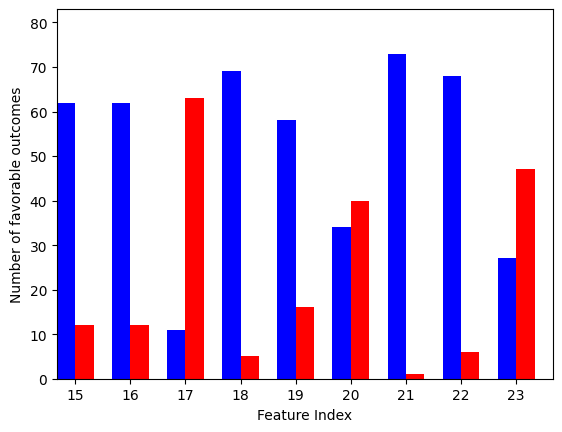

In [39]:
proportion_each_feature = []
for feature_idx in binary_features:
    n_fav_priv = np.sum((pred_train == 1) & (X_train[:,feature_idx] == 1))
    n_fav_unpr = np.sum((pred_train == 1) & (X_train[:,feature_idx] == 0))

    proportion_each_feature.append({"n_fav_priv": n_fav_priv, "n_fav_unpr": n_fav_unpr})

x_blue = 0.5 + 3 * np.arange(len(binary_features))
x_red = 1.5 + 3 * np.arange(len(binary_features))
y_blue = [d['n_fav_unpr'] for d in proportion_each_feature]
y_red = [d['n_fav_priv'] for d in proportion_each_feature]

fig, ax = plt.subplots()
ax.bar(x_blue, y_blue, color='blue', width=1, label='Unprivileged')
ax.bar(x_red, y_red, color='red', width=1, label='Privileged')
ax.set_xticks([1 + 3 * i for i in range(len(binary_features))])
ax.set_xticklabels([f'{idx}' for idx in binary_features])
ax.set_ylabel('Number of favorable outcomes')
ax.set_xlabel('Feature Index')

ax.set(xlim=(0, 3 * len(binary_features)), ylim=(0, max(y_blue + y_red) + 10))

plt.show()

In [43]:
aod_vals = []
aaod_vals = []
for feature_idx in binary_features:
    pred_train = model.predict(X_train)
    aod = compute_aod(y_train, pred_train, X_train[:,feature_idx])
    aaod = compute_aaod(y_train, pred_train, X_train[:,feature_idx])
    
    aod_vals.append(aod)
    aaod_vals.append(aaod)
    print(f'Feature {feature_idx}, AOD: {aod}, AAOD: {aaod}')

Feature 15, AOD: 0.08378460258245468, AAOD: 0.09261935204267502
Feature 16, AOD: -0.16691572964191437, AAOD: 0.16691572964191437
Feature 17, AOD: 0.07672517001628876, AAOD: 0.07672517001628876
Feature 18, AOD: -0.048602595925331116, AAOD: 0.048602595925331116
Feature 19, AOD: -0.02000165916979313, AAOD: 0.05837363749742508
Feature 20, AOD: 0.061013735830783844, AAOD: 0.061013735830783844
Feature 21, AOD: 0.024546829983592033, AAOD: 0.024546829983592033
Feature 22, AOD: 0.06496626138687134, AAOD: 0.06496626138687134
Feature 23, AOD: -0.015364238992333412, AAOD: 0.036403439939022064


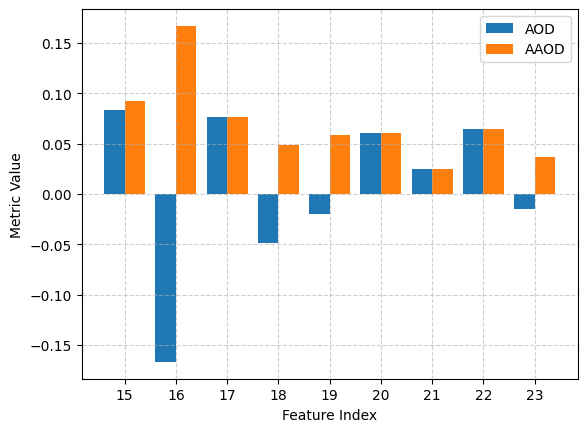

In [55]:
fig, ax = plt.subplots()
ax.bar(np.array(binary_features) - 0.2, aod_vals, width=0.4, label='AOD', color='C0')
ax.bar(np.array(binary_features) + 0.2, aaod_vals, width=0.4, label='AAOD', color='C1')
ax.set_xticks(binary_features)
ax.set_xticklabels([f'{idx}' for idx in binary_features])
ax.set_ylabel('Metric Value')
ax.set_xlabel('Feature Index')
ax.grid(ls='--', alpha=0.6)
ax.legend()
plt.show()

# Applying modifications into the LogisticRegression Function such that it supports regularizations.

In [6]:
std_model = LogisticRegression(lr=0.001, epochs=100)
l1_model = LogisticRegression(lr=0.001, epochs=100, regularization='l1', lambda_reg=0.1)
l2_model = LogisticRegression(lr=0.001, epochs=100, regularization='l2', lambda_reg=0.1)

std_model.fit(X_train, y_train)
l1_model.fit(X_train, y_train)
l2_model.fit(X_train, y_train)


In [9]:
models = {
    "Standard": std_model,
    "L1 Regularization": l1_model,
    "L2 Regularization": l2_model
}

for index_feature in binary_features:
    results = compare_fairness(models, X_test, y_test, index_feature)
    print(f'Feature {index_feature}:\n{results}\n')

Feature 15:
               Model Demographic Parity Equalized Odds
0           Standard        0.030303031    0.058644947
1  L1 Regularization          0.0506993    0.055492423
2  L2 Regularization        0.057109557     0.07375541

Feature 16:
               Model Demographic Parity Equalized Odds
0           Standard       -0.113986626     -0.4147977
1  L1 Regularization        -0.08054666    0.019133724
2  L2 Regularization       -0.016865365    -0.41262498

Feature 17:
               Model Demographic Parity Equalized Odds
0           Standard         0.07568903    0.027239148
1  L1 Regularization         0.15590294     0.14023548
2  L2 Regularization         0.15055534     0.12509891

Feature 18:
               Model Demographic Parity Equalized Odds
0           Standard         -0.1302739    0.046001796
1  L1 Regularization         -0.2079941   -0.066194974
2  L2 Regularization        -0.20281275   -0.050898477

Feature 19:
               Model Demographic Parity Equalized Odds
0